# Business Analytics : TP 4

## Generation d'explication en utilisant un modèle simple

Dans le précédent TP, on a utilisé un LLM pour déterminer si le client va résillier ces abonnement (churner) ou pas.

Dans ce TP, on va esssayé d'utilisé de modèle plus simple mais toujours explicable pour qu'on puissent donner l'explication à un LLM qui va nous génerer une belle phrase qui exeplique pourquoi le client à churner. Bien sur toujours sur le telco churn dataset : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

/!\ Attention, de base on utilise les quelques ligne que le prof avait proposé pour générer des token à partir du modèle bien plus gros. Ici n'ayant pas accès j'utilise juste un modèle charger par la library transformer.


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import export_text
from sklearn import tree
from sklearn.tree import _tree
import torch
from transformers import AutoTokenizer, pipeline, LlamaForCausalLM
from tqdm import tqdm

### Chargement données

Commence aussi par charger les données mais en faisant le TP, j'ai remarqué que dans la colonne *TotalChages*, des fois il y avait juste des espace " " et que je n'avais pas de data. Ici, avoir de trou comme ça empêchera de pouvoir caster en float toute la colonne et il faut donc regarder pour le corriger. Pour quand on l'a pas, on multiplie *tenure* x *MonthlyCharges* ça correspond au prix/mois x mois. Ce n'est pas une relation aussi simple car pour pas mal de personne leur abonnement à changer et ce n'est pas exactement ça mais ça donne une approximation quand l'information est absente. 

In [2]:
raw_dataset = pd.read_csv("telco_churn.csv")
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
full_dataset = pd.read_csv("telco_churn.csv")

full_dataset["MonthlyCharges"] = pd.to_numeric(full_dataset["MonthlyCharges"], errors="coerce") #convertit en numérique
full_dataset["tenure"] = pd.to_numeric(full_dataset["tenure"], errors="coerce")

total_numeric = pd.to_numeric(full_dataset["TotalCharges"], errors="coerce") #convertit
fallback = full_dataset["tenure"] * full_dataset["MonthlyCharges"] #fall back si échec
full_dataset["TotalCharges"] = total_numeric.fillna(fallback).astype(float) #remet tout dedans

full_dataset.drop_duplicates(inplace=True) #supprime les doublons
full_dataset.drop(columns=["customerID"], inplace=True) #supprime la colonne customerID car ne sert à rien


#split en train et test
train_df, test_df = train_test_split(full_dataset, test_size=0.2, random_state=2025)

dataset = {
    "train": train_df,
    "test": test_df
}
y_train = (train_df["Churn"] == "Yes").astype(int)
y_test = (test_df["Churn"] == "Yes").astype(int)
x_train = pd.get_dummies(dataset['train'].drop(columns=["Churn"]), drop_first=True)
x_test = pd.get_dummies(dataset['test'].drop(columns=["Churn"]), drop_first=True)

dataset = {
    "train": x_train,
    'y_train': y_train,
    "test": x_test,
    'y_test': y_test
}

dataset['train'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 32 to 6718
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5634 non-null   int64  
 1   tenure                                 5634 non-null   int64  
 2   MonthlyCharges                         5634 non-null   float64
 3   TotalCharges                           5634 non-null   float64
 4   gender_Male                            5634 non-null   bool   
 5   Partner_Yes                            5634 non-null   bool   
 6   Dependents_Yes                         5634 non-null   bool   
 7   PhoneService_Yes                       5634 non-null   bool   
 8   MultipleLines_No phone service         5634 non-null   bool   
 9   MultipleLines_Yes                      5634 non-null   bool   
 10  InternetService_Fiber optic            5634 non-null   bool   
 11  Internet

#### Remarques
J'ai bien passé les bonnes collone en int et le reste je l'ai passe en one-hot pour la suite

### Equilibrage
On va vérifier que le modèles est équilibré. Même si déjà fait au TP3 mais reste une bonne pratique.

In [4]:
def proportions ( counter ):
    total = sum( counter . values () )
    return { k : f"{v} ({v/ total :.3%})"for k , v in counter . items () }
train_counts = Counter ( dataset ["y_train"])
test_counts = Counter ( dataset ["y_test"])
print ("Train :", proportions ( train_counts ) )
print ("Test :", proportions ( test_counts ) )

Train : {0: '4121 (73.145%)', 1: '1513 (26.855%)'}
Test : {1: '356 (25.266%)', 0: '1053 (74.734%)'}


### Analyse de la covariance.

On peut également faire une matrice de covariance pour voir si y a des chose qui sont lié entre eux. Pour ça doit one-hot comme beaucoup de catégorielle.

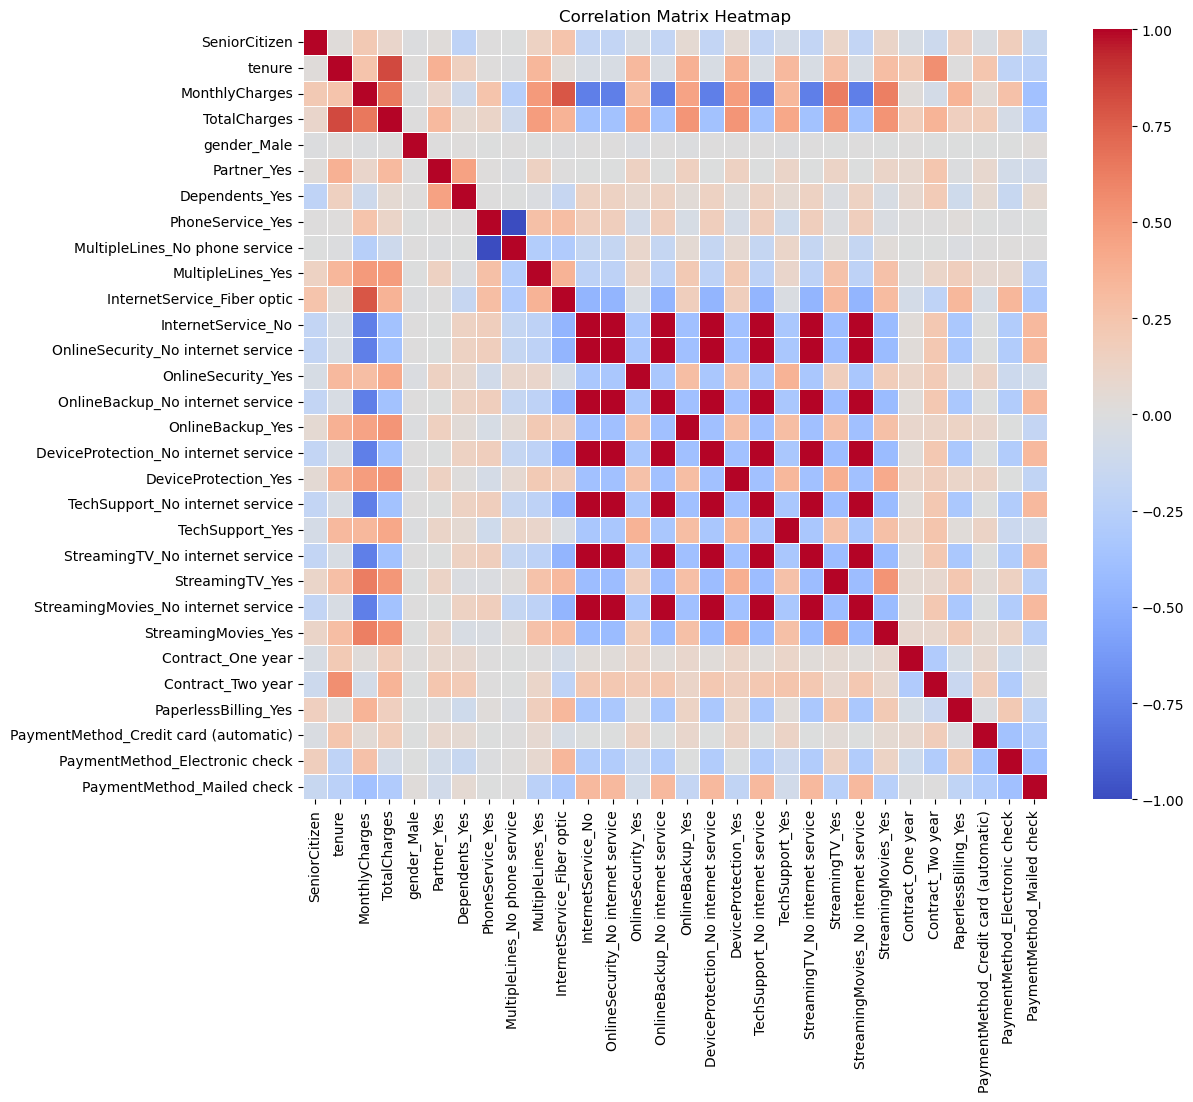

In [5]:
# calcule matrice de confustion

correlation_matrix = dataset['train'].corr()

# print
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Résultats
On voit que comme prévu, Tenure, MonthlyCharges et TotalCharges sont un peu corrêlé ce qui est exagéré en plus avec le fallback.

Cependant, on remarque que si le client n'as pas internet alors il ne possède aucun des protection en ligne, backup, .... Ce qui est logique car il ne peut même pas s'y connecter.

### Prédictions
Pour prédire, on a besoin d'un modèle explicable. Il en existe différent mais celui qui est le plus simple niveau explicabilité, c'est un arbre de décision qui n'a pas trop de profondeur. 

Accuracy: 0.7849538679914834

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86      1053
           1       0.62      0.38      0.47       356

    accuracy                           0.78      1409
   macro avg       0.72      0.65      0.67      1409
weighted avg       0.77      0.78      0.77      1409



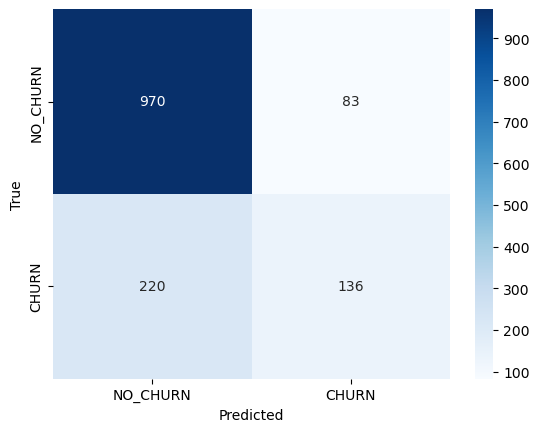

In [6]:
# train decision tree
clf = DecisionTreeClassifier(random_state=2025, max_depth=3) #limite à la profondeur 3 pour éviter overfitting et avoir arbre pas trop violent pour petit LLM
clf.fit(dataset['train'], dataset['y_train'])

# evalue le modèle
y_pred = clf.predict(dataset['test'])

print("Accuracy:", accuracy_score(dataset['y_test'], y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["NO_CHURN", "CHURN"],
            yticklabels=["NO_CHURN", "CHURN"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Résultat:

Comparé au TP précédent, on voit que les résultat sont au moins aussi bon si pas meileur. Cela montre bien qu'un LLM était overkill et qu'on pouvait se contenter de modèle bien plus simple.

Cependant, ce modèle ne reste pas très interesant étant donné que le recall est assez faible pour la catégorie Churn avec seulement 0,38. Pour limiter ça, on peut prédire la certitude que le modèle a est si torp faible créer une catégorie  "?" pour dire le modèle ne sait pas. Cela permettrait ansi pour quand on va tester la génréation d'explication d'avoir de cas ou on est sur de la classification et le LLM se trompera peut être moins. De plus, pas besoin de tous les trouver suffit d'en trouver suffisament pour que l'équipe marketing travail à 100% d'un point de vue business.

Accuracy: 0.5330021291696239

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.68      0.78      1053
           1       0.80      0.09      0.17       356
           2       0.00      0.00      0.00         0

    accuracy                           0.53      1409
   macro avg       0.57      0.26      0.32      1409
weighted avg       0.88      0.53      0.62      1409



/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

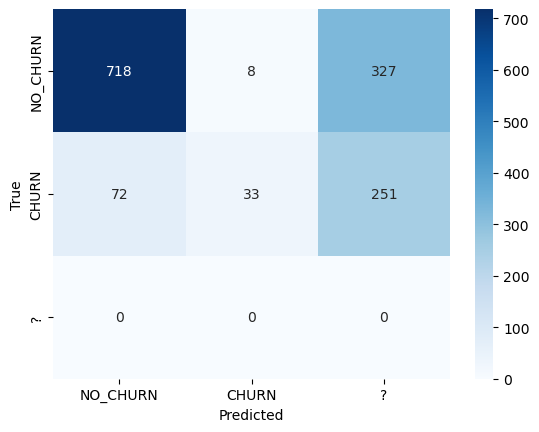


Accuracy of confident predictions: 0.9037304452466908


In [7]:
# confiance minimum que le modèle doit avoire
threshold = 0.65

# prédit les probas
probabilities = clf.predict_proba(dataset['test'])

# prend la proba max
max_probabilities = probabilities.max(axis=1) #prend max pour la classe

# prend les prédictions car on avait juste la sureté
predictions = clf.predict(dataset['test']) #prédit classe ce qui est overkill car pourrait juste utilsier un argmax par ligne des proba mais bon osef c'est rapide

# rempalce si inférieur au seuil par "?"
final_predictions = [
    pred if prob >= threshold else 2 
    for pred, prob in zip(predictions, max_probabilities)
]


print("Accuracy:", accuracy_score(dataset['y_test'], final_predictions))
print("\nClassification report:\n", classification_report(dataset['y_test'], final_predictions))


sns.heatmap(confusion_matrix(dataset['y_test'], final_predictions), annot=True, fmt="d", cmap="Blues",
            xticklabels=["NO_CHURN", "CHURN", '?'],
            yticklabels=["NO_CHURN", "CHURN", '?'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



# mesure l'accuracy sans les "?" donc à quel point il est bon quand il est pas dans la classe "?"
confident_indices = [i for i, pred in enumerate(final_predictions) if pred != 2]
confident_predictions = [final_predictions[i] for i in confident_indices]
confident_true_labels = dataset['y_test'].iloc[confident_indices]

print("\nAccuracy of confident predictions:", accuracy_score(confident_true_labels, confident_predictions))

#### Résulat:

on voit que ce système à notablement détruit la recall encore plus cependant, il reste une petite liste de candidat où le modèle est sur à 90% de ce qu'il fait donc il y a de grande chance qu'on peut lui faire confiance bien. Cela permet de faire passer la precision sur cette classe de 62 à 80% ce qui n'est pas néglieagle.

### Analyse des résultat du decision tree

On peut afficher tout les élément qu'il a utilisé ainsi qu'une représentation textuel et graphique de l'arbre de décisions.

                                       Importance
Feature                                          
tenure                                   0.527021
InternetService_Fiber optic              0.432038
TotalCharges                             0.028894
Contract_Two year                        0.012047
gender_Male                              0.000000
SeniorCitizen                            0.000000
Partner_Yes                              0.000000
Dependents_Yes                           0.000000
MultipleLines_No phone service           0.000000
PhoneService_Yes                         0.000000
MultipleLines_Yes                        0.000000
InternetService_No                       0.000000
OnlineSecurity_No internet service       0.000000
MonthlyCharges                           0.000000
OnlineSecurity_Yes                       0.000000
OnlineBackup_No internet service         0.000000
DeviceProtection_No internet service     0.000000
OnlineBackup_Yes                         0.000000


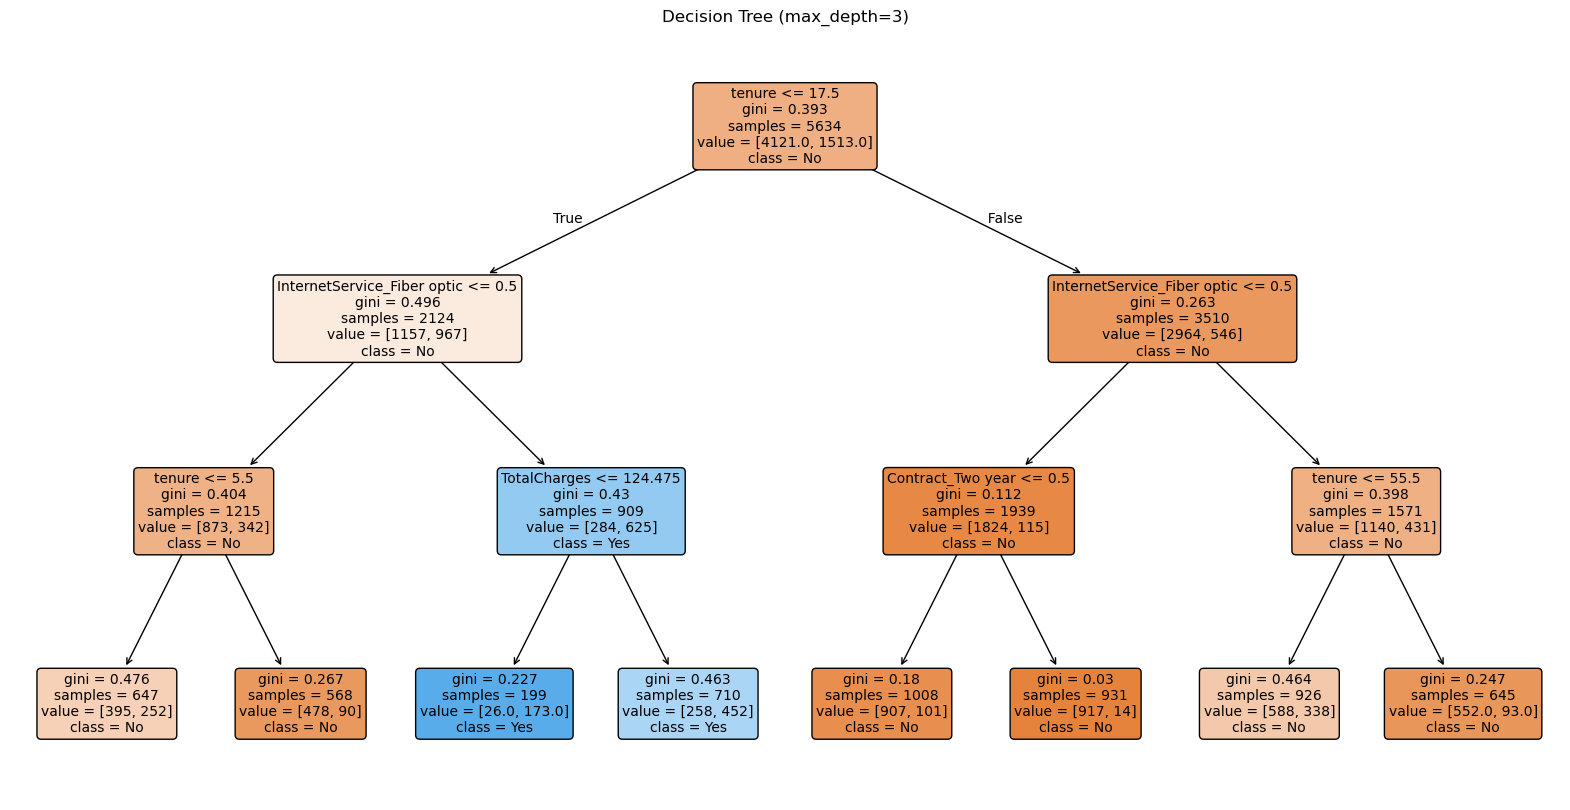

In [8]:
feat_imp = pd.Series(clf.feature_importances_, index=dataset['train'].columns).reset_index()
feat_imp.columns = ['Feature', 'Importance'] #créer colone importance
feat_imp.set_index('Feature', inplace=True)
print(feat_imp.sort_values(by='Importance', ascending=False))


print(dataset['train'].columns.tolist())
rules_text = export_text(clf, feature_names=dataset['train'].columns.tolist())
print(rules_text)

plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf,
    feature_names=dataset['train'].columns,
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Decision Tree (max_depth=3)")
plt.show()

#### Résultats :

On voit qu'on peut pas augmenter de trop la profondeur sinon après le text qu'il faudra fournir en contexte au LLM sera bien plus important et je risque d'avoir des problèmes d'hallucination.

Ce qu'on va faire aussi c'est la dataset le limiter à seulement les collones qu'ils utilise et renomer les colonnes avec des nom plus compréhensible pour aider au maximum le LLM.

In [57]:
to_predict_false = [i for i, pred in enumerate(final_predictions) if pred == 1] #récupère les indices des clients prédits comme churn pour le LLM
to_predict_true = [i for i, pred in enumerate(final_predictions) if pred == 0]

# nbr test
from_any_type = 5
to_predict = [] #ainsi on chrun, pas churn d'affilé pour mesure à quel point le LLM donne une bonne explication.
for i in range(from_any_type):
    to_predict.append((to_predict_false[i], False))
    to_predict.append((to_predict_true[i], True))

# arbre utilise que
feature_sorted = feat_imp
features = [i for i in feature_sorted.index if feature_sorted.loc[i, 'Importance'] > 0] #récupère que ceux qui sont utile

usefull_dataset = dataset['test'][features].iloc[[i[0] for i in to_predict]] #prend du dataset test, pour les features qu'on a besoin pour les client qu'on a besion

rename_dict = { #va renome de collones
    "tenure": "tenure per month", 
    "InternetService_Fiber optic": "Has internet fiber optic", 
    "TotalCharges" : "Total Charges", 
    "Contract_Two year": "Has to renew his contract every 2 year"
    }

usefull_dataset.rename(columns=rename_dict, inplace=True)

tree_text = export_text(clf, feature_names=clf.feature_names_in_, max_depth=3) #pas utilsable tel quel car juste dégelasse pour le llm
print(tree_text)

# part en récursif des noeuds de l'arbre et écrit une bellephras ecomplète
def tree_to_sentences(clf, feature_names, class_names=None, rename_dict=None):
    #prend feature de l'arbre
    tree = clf.tree_ 
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree.feature
    ]

    #va tout stocker dans une liste
    sentences = []

    #fait le recurisve, condition c'est pour le text que écrit
    def recurse(node, conditions):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree.threshold[node]

            # pour la partie gauche de l'arbre
            recurse(
                tree.children_left[node],
                conditions + [f"{rename_dict.get(name, name)} ≤ {threshold:.2f}"]
            )
            # pour la partie droite
            recurse(
                tree.children_right[node],
                conditions + [f"{rename_dict.get(name, name)} > {threshold:.2f}"]
            )
        else: #si plus d'enfant alors on est à une feuille et la peut écrire
            value = tree.value[node][0] #regarde la classe que donne
            predicted_class = value.argmax() #peut en avoir deux donc prend la plus probalb 
            class_label = (
                class_names[predicted_class]
                if class_names is not None
                else predicted_class
            )

            sentence = (
                "If " + " and ".join(conditions)
                + f", then the predicted class is {class_label}."
            )
            sentences.append(sentence)

    recurse(0, [])
    return sentences

sentences = tree_to_sentences(clf, dataset['train'].columns.tolist(), class_names=["No", "Yes"], rename_dict=rename_dict)
print(sentences)

|--- tenure <= 17.50
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- tenure <= 5.50
|   |   |   |--- class: 0
|   |   |--- tenure >  5.50
|   |   |   |--- class: 0
|   |--- InternetService_Fiber optic >  0.50
|   |   |--- TotalCharges <= 124.47
|   |   |   |--- class: 1
|   |   |--- TotalCharges >  124.47
|   |   |   |--- class: 1
|--- tenure >  17.50
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- Contract_Two year <= 0.50
|   |   |   |--- class: 0
|   |   |--- Contract_Two year >  0.50
|   |   |   |--- class: 0
|   |--- InternetService_Fiber optic >  0.50
|   |   |--- tenure <= 55.50
|   |   |   |--- class: 0
|   |   |--- tenure >  55.50
|   |   |   |--- class: 0

['If tenure per month ≤ 17.50 and Has internet fiber optic ≤ 0.50 and tenure per month ≤ 5.50, then the predicted class is No.', 'If tenure per month ≤ 17.50 and Has internet fiber optic ≤ 0.50 and tenure per month > 5.50, then the predicted class is No.', 'If tenure per month ≤ 17.50 and Has internet fi

Avec ça, on a tout qui est prête pour créer le prompt et génerer les explications.

In [17]:
#prend modèle déjà quantifié pour meilleur résultata
model_name = "NousResearch/Hermes-3-Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = LlamaForCausalLM.from_pretrained( #force le chargent en 4Bit comme la doc le souhaite
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    load_in_8bit=False,
    load_in_4bit=True,
)

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [54]:
def row_to_text(row):
    parts = []
    for col in row.keys():
        if isinstance(row[col], float):
            parts.append(f"{col}: {row[col]:.3f}")
        else:
            parts.append(f"{col}: {row[col]}")
    return " | ".join(parts)

def write_strategie(text, model, tokenizer, trees_sentences):
    messages = [
        {
            "role": "system",
            "content": (
                "You are an analytical assistant specialized in explaining customer churn.\n\n"
                "Decision tree rules (for internal reasoning only):\n"
                + "\n".join(trees_sentences) +
                "\n\n"
                "Task:\n"
                "Given a customer profile, explain why the customer is predicted to churn or not churn.\n\n"
                "Output constraints:\n"
                "- EXACTLY one sentence\n"
                "- Max 2 sentences\n"
                "- No rule enumeration\n"
                "- No thresholds or numeric cutoffs\n"
                "- No reasoning steps\n"
            )
        },
        {
            "role": "user",
            "content": text
        }
    ]

    #définit pipeline de génération de texte
    pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
    )

    # applique chat template pour créer le bon format comme le modèle demande avec <|im_start|>assistant et <|im_end|> et autre
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True)

    #génère le réponse
    response = pipe(
    prompt,
    max_new_tokens=140, #limite longueur pour éviter qu'il raconte sa vie
    do_sample=False, # askip doit suppirmer sampling pour mieux contôler sortie et mieux suivre les conssignes
    repetition_penalty=1.1, # veut surtout pas que se répète
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    return_full_text=False
    )[0]["generated_text"] #garde que le texte généré

    return response.strip()

In [62]:
for elem in tqdm(usefull_dataset.index):
    label = to_predict[usefull_dataset.index.get_loc(elem)][1]
    text_input = row_to_text(usefull_dataset.loc[elem]) + f" | Predicted Churn: {'Yes' if label else 'No'}"
    print(f"\nCustomer data:\n{text_input}\n")
    strategie = write_strategie(text_input, model, tokenizer, sentences)
    print(f"LLM Explanation:\n{strategie}\n")
    

  0%|          | 0/10 [00:00<?, ?it/s]Device set to use cuda:0



Customer data:
tenure per month: 1 | Total Charges: 69.350 | Has internet fiber optic: True | Has to renew his contract every 2 year: False | Predicted Churn: No



 10%|█         | 1/10 [00:03<00:35,  3.98s/it]Device set to use cuda:0


LLM Explanation:
This customer has recently started their service with a short tenure of just one month. Despite having high-speed internet fiber optics, which typically leads to lower churn rates, they have not had to renew their contract within two years, suggesting a higher likelihood of churning compared to new customers. However, given their very brief tenure, it's likely that this customer will remain with the company for now.


Customer data:
tenure per month: 37 | Total Charges: 2345.200 | Has internet fiber optic: False | Has to renew his contract every 2 year: False | Predicted Churn: Yes



 20%|██        | 2/10 [00:09<00:39,  4.94s/it]Device set to use cuda:0


LLM Explanation:
This customer has been with the company for over three years, which is typically longer than the average tenure before churning. Despite having high monthly charges of $2345.20, their internet service does not include fiber optics, suggesting they may be unsatisfied with this aspect of their service. Additionally, they have not had to renew their contract in two years, indicating a lack of ongoing issues that would require frequent updates. While these factors suggest a higher likelihood of churning, it's also possible that the customer is simply content with their current service and will continue using the provider.


Customer data:
tenure per month: 1 | Total Charges: 75.450 | Has internet fiber optic: True | Has to renew his contract every 2 year: False | Predicted Churn: No



 30%|███       | 3/10 [00:14<00:33,  4.73s/it]Device set to use cuda:0


LLM Explanation:
This customer has recently started their service with a short tenure of just one month. Despite having high-speed internet fiber optics, which typically indicates a modern and technologically savvy household, they have not yet renewed their contract after two years. While these factors suggest a low likelihood of churning, the relatively brief duration of their service may indicate that they are still new to the company and could potentially leave if unsatisfied with their experience thus far.


Customer data:
tenure per month: 52 | Total Charges: 2610.650 | Has internet fiber optic: False | Has to renew his contract every 2 year: False | Predicted Churn: Yes



 40%|████      | 4/10 [00:19<00:29,  4.94s/it]Device set to use cuda:0


LLM Explanation:
This customer has been with the company for over five years, which suggests a strong commitment. Despite having high monthly charges of $2610.65, they have chosen not to renew their contract every two years, indicating a willingness to explore alternative options. The lack of internet fiber optic service further suggests that they may be looking for more competitive rates or faster, more reliable connections. While their long tenure and relatively high charges might suggest a loyal customer, the combination of factors points towards a higher likelihood of churning compared to other customers.


Customer data:
tenure per month: 1 | Total Charges: 75.550 | Has internet fiber optic: True | Has to renew his contract every 2 year: False | Predicted Churn: No



 50%|█████     | 5/10 [00:23<00:23,  4.80s/it]Device set to use cuda:0


LLM Explanation:
This customer has recently started their service with a short tenure of just one month. Despite having high-speed internet fiber optics, which typically indicates a modern and technologically savvy household, they have not yet renewed their contract after two years. While these factors suggest a low likelihood of churning, the relatively brief duration of their service may indicate that they are still new to the company and could potentially leave if unsatisfied with their experience thus far.


Customer data:
tenure per month: 20 | Total Charges: 416.450 | Has internet fiber optic: False | Has to renew his contract every 2 year: False | Predicted Churn: Yes



 60%|██████    | 6/10 [00:27<00:17,  4.27s/it]Device set to use cuda:0


LLM Explanation:
This customer has been with the company for over two years, which suggests a strong commitment. However, they have not renewed their contract, indicating dissatisfaction with their current service. The high total charges also suggest a lack of value received, further contributing to the likelihood of churning.


Customer data:
tenure per month: 1 | Total Charges: 69.400 | Has internet fiber optic: True | Has to renew his contract every 2 year: False | Predicted Churn: No



 70%|███████   | 7/10 [00:31<00:12,  4.26s/it]Device set to use cuda:0


LLM Explanation:
This customer has recently started their service with a short tenure of just one month. Despite having high-speed internet fiber optics, which typically leads to lower churn rates, they have not had to renew their contract within two years, suggesting a higher likelihood of churning compared to new customers. However, given their very brief tenure, it's likely that this customer will remain with the company for now.


Customer data:
tenure per month: 64 | Total Charges: 6314.350 | Has internet fiber optic: True | Has to renew his contract every 2 year: False | Predicted Churn: Yes



 80%|████████  | 8/10 [00:35<00:08,  4.24s/it]Device set to use cuda:0


LLM Explanation:
This customer has been with the company for over five years, which suggests a strong commitment. However, they have opted for high-speed internet, which could indicate dissatisfaction with their current service. Additionally, despite not having to renew their contract every two years, the total charges of $6,314.35 are unusually high, suggesting potential issues that may lead them to consider leaving the provider.


Customer data:
tenure per month: 1 | Total Charges: 69.900 | Has internet fiber optic: True | Has to renew his contract every 2 year: False | Predicted Churn: No



 90%|█████████ | 9/10 [00:39<00:04,  4.25s/it]Device set to use cuda:0


LLM Explanation:
This customer has recently started their service with a short tenure of just one month. Despite having high-speed internet fiber optics, which typically leads to lower churn rates, they have not had to renew their contract within two years, suggesting a higher likelihood of churning compared to new customers. However, given their very brief tenure, it's likely that this customer will remain with the company for now.


Customer data:
tenure per month: 18 | Total Charges: 1156.350 | Has internet fiber optic: False | Has to renew his contract every 2 year: False | Predicted Churn: Yes



100%|██████████| 10/10 [00:45<00:00,  4.54s/it]

LLM Explanation:
This customer has been with the company for nearly two years, which is relatively short compared to most customers. Despite having high monthly charges of $1156.35, they have not renewed their contract every two years, indicating a lack of commitment. The customer also does not have access to the company's high-speed fiber-optic internet service, which could be a factor in their decision to stay away from the company. Overall, these factors suggest that this customer may be more likely to churn, or leave the company, in the near future.

